# EC: Exercise 6 (Memetic algorithms vs. simple EAs)

In [26]:
import numpy as np
import numpy.random as rnd
import matplotlib.pyplot as plt
from abc import ABC, abstractmethod
from timeit import default_timer as timer
import yappi

In [27]:
#loading in the given .txt data:
txt_data = np.loadtxt("file-tsp.txt", unpack = False)
txt_data_size = np.shape(txt_data)[0]

**(a)**<br>
Evolutionary algorithm abstract base class:

In [28]:
class ABC_EA(ABC):
    
    @abstractmethod
    def __update_fitness(self):
        '''
            Update the fitness value for the current value of _d_pop.
        '''
        ...

       
    def __init__(self, pop_size, init_pop, cross_prob, mut_prob, rng):
        '''
            Initialize all the necessary values.
            Parameters:
            ----------------------------------
            pop_size: [positive int]
                Population size.
                
            init_pop: [array]
                Initial population.
                
            cross_prob: [float between 0 and 1]
                Probability for crossover to occur.
                
            mut_prob: [float between 0 and 1]
                Probability for mutation to occur.
            
            rng: [random number generator].
        
        '''
        assert 0 <= cross_prob, mut_prob <= 1
              # random number generator:
        self._d_rng = rng
              # population size:
        self._d_pop_size = pop_size
              # population:
        self._d_pop = init_pop
              # population fitness values:
        self._d_fitness = np.zeros(pop_size)
              # crossover probability:
        self._d_cross_prob = cross_prob
              # mutability probability:
        self._d_mut_prob = mut_prob
              # array containing the max fitness each epoch:
        self._d_max_fit = np.array([])
              # array containing the avg. fitness each epoch:
        self._d_avg_fit = np.array([])
              # time taken by optimization:
        self._d_time = 0.
              # updating the fitness:
        self.__update_fitness()
        
    def update_hyps(cross_prob = 'UNDEF', mut_prob = 'UNDEF'):
        '''
            Changes the hyper parameters
            Parameters:
            ----------------------------------
            cross_prob: [float between 0 and 1]
                Probability for crossover to occur.
                
            mut_prob: [float between 0 and 1]
                Probability for mutation to occur.            
        '''
        if cross_prob != 'UNDEF':
            assert 0 <= cross_prob <= 1
            self._d_cross_prob = cross_prob
        if mut_prob != 'UNDEF':
            assert 0 <= mut_prob <= 1
            self._d_mut_prob = mut_prob
            
    
    def __select(self, numb):
        '''
            Select `numb' members from the current population.
            Parameters:
            ----------------------------------
            numb: [positive int]
                Number of members to generate.
        '''
        return self._d_rng.choice(self._d_pop, numb, \
                    p = (self._d_fitness) / np.sum(self._d_fitness))
        
         # to be defined:    
    @abstractmethod
    def __crossover(self, parents, prob):
        '''
            Perform crossover on `parents'.
            Parameters:
            ----------------------------------
            parents: [Array of elements of the same type as _d_pop].
                        
            prob: [float between 0 and 1]
                The crossover probability.
        '''
        ...
    
    
    @abstractmethod
    def __mutate(self, children, prob):
        '''
            Perform a mutation on `children' with probability `prob'.
            Parameters:
            ----------------------------------
            children: [Array of elements of the same type as _d_pop].
            
            prob: [float between 0 and 1]
                The mutation probability.
        '''
        ...

    def __give_additional(self):
        '''
            Print / plot additional information, if the plot option is given in optimize.
        '''
        pass
    
    
    def optimize(self, maxiter, crit = 0, mut_prob = -1, cross_prob = -1,
                 ret = False, plot = False, title = '', time = False, time_limit = 'inf'):
        '''
            Perform the optimization algorithm, until either maxiter epochs have 
            passed, or until the absolute difference of the average fitness 
            between consecutive epochs does not change more than `crit'.
            Parameters:
            ----------------------------------
            maxiter: [positive int]
                Maximum number of iterations to perform.
                
            crit: [non-negative float]
                Stopping criterion.
                
            mut_prob: [float between 0 and 1]
                Mutation probability (for the default -1 we pick standard value).
            
            cross_prob: [float between 0 and 1]
                Crossover probability (for the default -1 we pick standard value).
                
            ret: [boolean]
                If true, we return d_avg_fit, d_max_fit, the individual with the
                highest firness and whether we stopped early.
                
            plot: [boolean]
                Decides whether we plot the progress.
                
            title: [string]
                The title of the plot.
            
            time: [bool]
                If true, prints the total time taken by the optimization.
                
            time_limit: [positive number | 'inf']
                Stops the current run when it starts to exceed time_limit.
        '''
          # start timer:
        start = timer()
        
          # check input:
        assert maxiter >= 0
        
        start_length = np.size(self._d_avg_fit)
        
        temp_avg_fit = np.zeros(maxiter, dtype = int)
        temp_max_fit = np.zeros(maxiter, dtype = int)
        
        stopped_at = maxiter
        crit_achieved = False
        
        if start_length > 2 and \
             np.abs(self._d_avg_fit[-1] - self._d_avg_fit[-2]) < crit:
            crit_achieved = True
            stopped_at = 0
            
          # the algorithm:
        for idx in range(maxiter):
            if crit_achieved or idx > 2 and \
                  np.abs(temp_avg_fit[idx - 1] - temp_avg_fit[idx - 2]) < crit:
                stopped_at = idx
                crit_achieved = True
                break
            
            if time_limit != 'inf' and timer() - start >= time_limit:
                stopped_at = idx
                break
                
            selected = self.__select(self._d_pop_size)
            children = self.__crossover(selected)
            self._d_pop = self.__mutate(children)
            self.__update_fitness()
            temp_max_fit[idx] = np.max(self._d_fitness)
            temp_avg_fit[idx] = np.mean(self._d_fitness)
            
          # update timer (we do not want to count the time plotting takes):
        self._d_time += timer() - start
            
        self._d_avg_fit = np.append(self._d_avg_fit, temp_avg_fit[:stopped_at])
        self._d_max_fit = np.append(self._d_max_fit, temp_max_fit[:stopped_at])
        
          # plotting:
        if plot:
            plt.title(title)
            plt.xlabel('Generation')
            plt.ylabel('Fitness')
            plt.plot(np.arange(start_length + stopped_at, dtype = int), \
                     self._d_avg_fit, label = 'Average fitness')
            plt.plot(np.arange(start_length + stopped_at, dtype = int), \
                     self._d_max_fit, label = 'Best fitness')
            plt.legend()
            plt.show()
            self.__give_additional()
            
        if time:
            print('Time taken:', self._d_time, 'seconds')
            
        best_specimen = self._d_pop[np.argmax(self._d_fitness)]
        
        if ret:    
            return self._d_avg_fit, self._d_max_fit, best_specimen, crit_achieved

Initializing the population for TSP:

In [29]:

  # K-nearest neighbors as initialization, as suggested in [1]:
def KNN_init(data, pop_size,  rng = rnd.default_rng()):
    
    data_size = np.shape(data)[0]
              # indexing the data will be useful later:
    idxed_data = np.concatenate((data, \
                   np.array([np.arange(data_size, dtype = int)]).T), axis = 1)
              # the to be generated population:
    perms = np.zeros(pop_size, dtype = object)
              # generating the population:
    for idx in range(pop_size):
              # choosing a starting position:
        start_pos = rnd.choice(np.arange(data_size))
        perm = [start_pos]
          
              # choosing the nearest neigbor as the next place to visit
              # (recursive function):
        def find_nearest(arr_o_opts, current):
            
              # base case:
            if arr_o_opts.size == 0:
                return []
            
              # find index of nearest neighbor:
            distances = np.linalg.norm(arr_o_opts[:, :2] - current[:2], axis = 1)
            new_idx = np.argmin(distances)
            new = int(arr_o_opts[new_idx, 2])
              
              # updating variables
            current = arr_o_opts[new_idx]
            arr_o_opts = np.delete(arr_o_opts, new_idx, axis = 0)
            
              # recursive call:
            return [new] + find_nearest(arr_o_opts, current)
        
              # creating input and calling function:
        current = idxed_data[start_pos]
        arr_o_opts = np.delete(idxed_data, start_pos, 0)
        perm += find_nearest(arr_o_opts, current)
              # add to population:
        perms[idx] = perm
    return perms

In [30]:
  # Random initialization:
def RND_init(data, pop_size,  rng = rnd.default_rng()):   
    data_size = np.shape(data)[0]
              # the to be generated population:
    perms = np.zeros(pop_size, dtype=object)
              # generating the population:       
    for idx in range(pop_size): 
        perm_size1 = np.shape(data)[0]
        perms[idx] = list(rnd.choice(np.arange(perm_size1), perm_size1, replace = False))
    return perms

Performing a sanity check:

In [31]:
test_pop_size = 10          
test_init = KNN_init(txt_data, test_pop_size)

for idx in range(test_pop_size):
    assert sum(test_init[idx]) == (txt_data_size) * (txt_data_size - 1) / 2

Defining crossover for TSP:

In [32]:
def crossover_on_perms(perm1, perm2, pos1, pos2):
    perm_len = len(perm1)
    assert 0 < pos1 < pos2 < perm_len
    
    def init_new_perm(choice):
        assert choice == 1 or choice == 2
        if choice == 1:
            perm = perm1
            
        elif choice == 2:
            perm = perm2
            
        new_perm =  [-1] * perm_len
        new_perm[pos1 : pos2] = perm[pos1 : pos2]
        return new_perm
    
    new_perm1 = init_new_perm(1)
    new_perm2 = init_new_perm(2)
    
    def fill_in_the_blanks(child_partial, other_parent):
        order = [idx % perm_len for idx in range(pos2, perm_len + pos2)]
        permute_parent = [other_parent[idx] for idx in order]
        up_to = 0
        for idx in order:
            if child_partial[idx] != -1:
                break
            for idy in range(up_to, perm_len):
                if permute_parent[idy] in child_partial[pos1 : pos2]:
                    continue
                else:
                    child_partial[idx] = permute_parent[idy]
                    up_to = idy + 1
                    break
    
    fill_in_the_blanks(new_perm1, perm2)
    fill_in_the_blanks(new_perm2, perm1)
    
    return new_perm1, new_perm2

Sanity check comparing defined function to the example from the slides:

In [33]:
list1 = [3, 4, 7, 2, 1, 6, 4, 8]
list2 = [2, 5, 7, 6, 8, 1, 3, 4]
pos1 = 2
pos2 = 6
children = crossover_on_perms(list1, list2, pos1, pos2)
print('first child =', children[0])
print('second child =', children[1])

first child = [5, 8, 7, 2, 1, 6, 3, 4]
second child = [4, 2, 7, 6, 8, 1, 4, 3]


Defining permutation for TSP:

In [34]:
def mutation_on_perms(perm, pos1, pos2):
    assert  0 <= pos1 < pos2 <= len(perm)
    
    temp_val1 = perm[pos1]
    temp_val2 = perm[pos2]
    
    perm[pos1] = temp_val2
    perm[pos2] = temp_val1
    
    return perm

Sanity check comparing defined function to the example from the slides:

In [35]:
list3 = [5, 8, 7, 2, 1, 6, 3, 4]

print(mutation_on_perms(list3, 2, 5))

[5, 8, 6, 2, 1, 7, 3, 4]


**Pure EA algorithm for TSP:**

In [36]:
class EA_TSP(ABC_EA):
    
    def __tot_distance(self, perm):
        return np.sum(np.linalg.norm(self._d_data[perm[1:]] - self._d_data[perm[:-1]], axis = 1))
    
    
    @staticmethod
    def fitness_tf(x):
        return (1000 / x) ** 4
    
    
    def _ABC_EA__update_fitness(self):
        for idx in range(self._d_pop_size):
            self._d_fitness[idx] = self.fitness_tf(self.__tot_distance(self._d_pop[idx]))

            
    def __init__(self, data, pop_size, init_fun = RND_init, cross_prob = 0.4, mut_prob = 0.1, rng = rnd.default_rng()):
        '''
            Parameters:
            ----------------------------------
            init_fun [function : (data, pop_size, rng) |---> population]
                Should initialize the population.
                
            See base class for other parameters.
        '''
        assert callable(init_fun)
        self._d_data = data
        super().__init__(pop_size, init_fun(data, pop_size, rng), \
                         cross_prob, mut_prob,  rng)
            
            
          # perform a local optimization (none here):
    def __local_opt(self, child):
        return child
        
        
    def _ABC_EA__crossover(self, parents):
        parents_size = np.shape(parents)[0]
        perm_size = len(parents[0])
        children = parents
        to_cross = np.where(self._d_rng.binomial(1, self._d_cross_prob, size = parents_size))[0]
        
        for idx in range(np.size(to_cross)):
            if idx + 1 == np.size(to_cross):
                break
            posits = np.sort(self._d_rng.choice(np.arange(1, perm_size), 2, replace = False))
            children[to_cross[idx]], children[to_cross[idx + 1]] = \
                crossover_on_perms(parents[to_cross[idx]], parents[to_cross[idx + 1]], posits[0], posits[1])
            children[to_cross[idx]] = self.__local_opt(children[to_cross[idx]])
            children[to_cross[idx + 1]] = self.__local_opt(children[to_cross[idx + 1]])
        return children
    
        
    def _ABC_EA__mutate(self, children):
        children_size = np.shape(children)[0]
        child_size = len(children[0])
        to_mutate = np.where(self._d_rng.binomial(1, self._d_mut_prob, children_size))[0]
        if np.size(to_mutate) != 0:
            for idx in to_mutate:
                posits = np.sort(self._d_rng.choice(np.arange(child_size), 2, replace = False))
                children[idx] = mutation_on_perms(children[idx], posits[0], posits[1])
                children[idx] = self.__local_opt(children[idx])
        return children
    
    def _ABC_EA__give_additional(self):
        distances = np.zeros(self._d_pop_size, dtype = object)
        for idx in range(self._d_pop_size):
            distances[idx] = self.__tot_distance(self._d_pop[idx])
        print('Average distance:', np.mean(distances))
        print('Shortest distance:', np.min(distances))
        

Testing the implementation of EA_TSP:

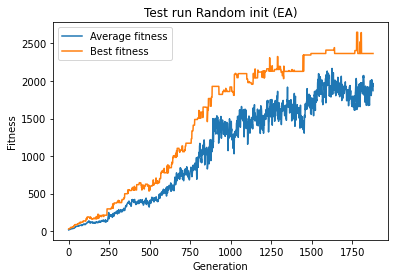

Average distance: 156.0999949951088
Shortest distance: 143.37601112050413
Time taken: 30.013204900002165 seconds
--------------------------------------------------


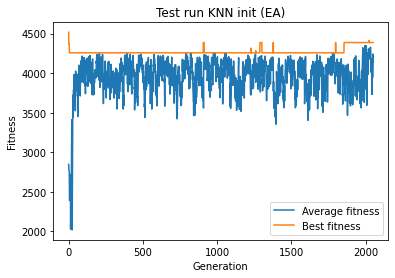

Average distance: 126.1571643791745
Shortest distance: 122.87069918004454
Time taken: 30.00060850000591 seconds

best rout: [6, 4, 3, 1, 0, 8, 14, 9, 10, 11, 5, 2, 15, 18, 22, 25, 24, 17, 20, 23, 30, 33, 32, 38, 40, 44, 41, 42, 36, 37, 34, 26, 47, 48, 49, 43, 46, 45, 35, 31, 28, 29, 21, 16, 13, 7, 12, 19, 27, 39]


In [37]:
ev_alg = EA_TSP(txt_data, 200,  mut_prob = 0.01, cross_prob = 0.2)
ev_alg.optimize(10000, title = 'Test run Random init (EA)', plot = True, time = True, time_limit = 30)

print('--------------------------------------------------')

ev_alg1 = EA_TSP(txt_data, 200, KNN_init, mut_prob = 0.01, cross_prob = 0.2)
arr_avg, arr_max, best, _ = ev_alg1.optimize(10000, title = 'Test run KNN init (EA)', \
                                             plot = True, ret = True, time = True, time_limit = 30)

print('\nbest rout:', best)

**Defining MA for TSP:**

In [40]:
class MA_TSP(EA_TSP):

    def __init__(self, data, pop_size, init_fun = RND_init, cross_prob = 0.4, \
                 mut_prob = 0.1, opt_it = 'inf', rng = rnd.default_rng()):
        '''
            Parameters:
            ----------------------------------
            opt_int [positive integer | 'inf']:
                If `opt_int' is 'inf', then 2-opt will run untill no improvements
                are made. If `opt_int' is an integer, we will apply 2-opt, `opt_int'
                at most number of times every time we apply the local optimization.
                
            See base class for other parameters.
        '''
        super().__init__(data, pop_size, init_fun, cross_prob, mut_prob, rng)
        self._d_opt_it = opt_it

    
    def _EA_TSP__local_opt(self, child):
        opt_it = self._d_opt_it
        current_dist = self._EA_TSP__tot_distance(child)
        current_child = child
          # apply 2-opt untill no improvements are made, or untill opt_it is zero:
        while True:
            if opt_it == 0:
                break
            
            change = False
            
            for idx in range(len(self._d_data[0])):
                for idy in range(idx + 1, len(self._d_data[0])):
                    child, new_dist = self.__two_opt_step(child, idx, idy)

                    if new_dist < current_dist:
                        change = True
                        current_dist = new_dist
                        current_child = child

            if opt_it != 'inf':
                opt_it -= 1
            if not change:
                break
        return current_child
    
    
    def update_hyps(self, cross_prob = 'UNDEF', mut_prob = 'UNDEF', opt_it = 'UNDEF'):
        super().update_hyps(cross_prob = 'UNDEF', mut_prob = 'UNDEF')
        if opt_it != 'UNDEF':
            self._d_opt_it = opt_it
            
        
    def __two_opt_step(self, perm, pos1, pos2):
        assert 0 <= pos1 < pos2 <= len(perm)
          # reversing has no effect:
        if pos1 == 0 and pos2 == len(perm):
            return perm
        
        current_dist = self._EA_TSP__tot_distance(perm)
          # exploting that the current distance is similar to the new distance (in its path)
        alt_dist = current_dist + np.linalg.norm(self._d_data[perm[pos1 - 1]] - self._d_data[perm[pos1]]) \
                                + np.linalg.norm(self._d_data[perm[pos2 - 1]] - self._d_data[perm[pos2]]) \
                                - np.linalg.norm(self._d_data[perm[pos1 - 1]] - self._d_data[perm[pos2 - 1]]) \
                                - np.linalg.norm(self._d_data[perm[pos1]] - self._d_data[perm[pos2]])

        if alt_dist < current_dist:
            return perm[: pos1] + perm[pos1 : pos2][:: -1] + perm[pos2 :], alt_dist
        else:
            return perm, current_dist


Testing the implementation of MA_TSP:

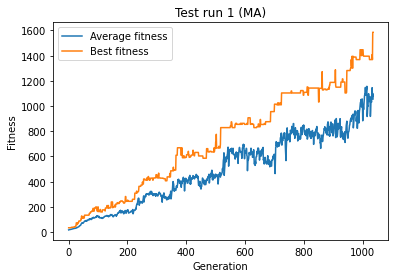

Average distance: 179.89467631785737
Shortest distance: 158.43722491992605
Time taken: 30.01741459999903 seconds
--------------------------------------------------


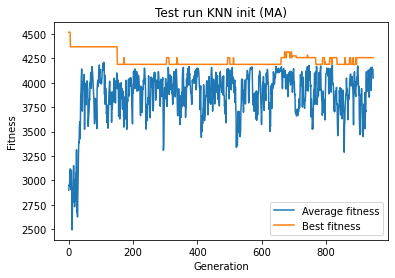

Average distance: 126.27538960017199
Shortest distance: 123.79756606535031
Time taken: 30.02119500000117 seconds

best rout: [6, 4, 3, 1, 0, 8, 14, 9, 10, 11, 5, 2, 15, 18, 22, 25, 24, 17, 20, 23, 30, 33, 32, 38, 40, 44, 41, 42, 36, 37, 34, 26, 47, 48, 49, 43, 46, 45, 35, 31, 28, 29, 21, 16, 13, 12, 7, 19, 27, 39]


In [41]:
mn_alg = MA_TSP(txt_data, 200,  mut_prob = 0.01, cross_prob = 0.2)
mn_alg.optimize(10000, title = 'Test run 1 (MA)', plot = True, time = True, time_limit = 30)

print('--------------------------------------------------')

mn_alg1 = MA_TSP(txt_data, 200, KNN_init, mut_prob = 0.01, cross_prob = 0.2)
arr_avg, arr_max, best, _ = mn_alg1.optimize(10000, title = 'Test run KNN init (MA)', \
                                             plot = True, ret = True, time = True, time_limit = 30)

print('\nbest rout:', best)

**TEMP:** Below we do a bit of profiling, I think you need to restart the kernel every time.

In [ ]:
yappi.set_clock_type("cpu")
yappi.start()

ev_alg1 = MA_TSP(txt_data, 1000, KNN_init, mut_prob = 0.01, cross_prob = 0.2)
ev_alg1.optimize(1000, time_limit = 120)

stats = yappi.get_func_stats().sort('ttot').strip_dirs()
stats.print_all(columns={0: ('name', 45), 1: ('ncall', 10), 2: ('tsub', 8), 3: ('ttot', 8), 4: ('tavg', 8)})

**(b)**

In [23]:

  # create comparative plots:
def create_data(numb_iter, title, data, maxiter, pop_size, init_fun = RND_init, \
                cross_prob = 0.2, mut_prob = 0.05, time_limit = 'inf'):
    
    fig, axs = plt.subplots(2, 2, figsize=(10, 8), constrained_layout = True)
      # obtain results:
    def perform_runs(method_construct):
        method_avg = np.zeros(numb_iter, dtype = object)
        method_best = np.zeros(numb_iter, dtype = object)

        for idx in range(numb_iter):
            ev_alg = method_construct(data, pop_size, init_fun = init_fun, mut_prob = mut_prob, \
                                      cross_prob = cross_prob)
            avg, best, _, _ = ev_alg.optimize(maxiter, ret = True, time_limit = time_limit)

            method_avg[idx]  = avg
            method_best[idx] = best
            
        return method_avg, method_best
    
    EA_avg, EA_best = perform_runs(EA_TSP)
    MA_avg, MA_best = perform_runs(MA_TSP)
    
      # make subplot:
    def make_plot(idx, idy, runs, header):
        for run in runs:
            axs[idx, idy].set_title(header + title)
            axs[idx, idy].plot(np.arange(np.size(run)),  1000 / (run) ** (1/4))
            axs[idx, idy].set_xlabel("Generations")
            axs[idx, idy].set_ylabel("Distance")
    
    make_plot(0, 0, EA_avg, 'EA avg: ')
    make_plot(1, 0, EA_best, 'EA best: ')
    make_plot(0, 1, MA_avg, 'MA avg: ')
    make_plot(1, 1, MA_best, 'MA best: ')

    
    

In [ ]:
# create_data(10, 'txt data', txt_data, 1500, 200)

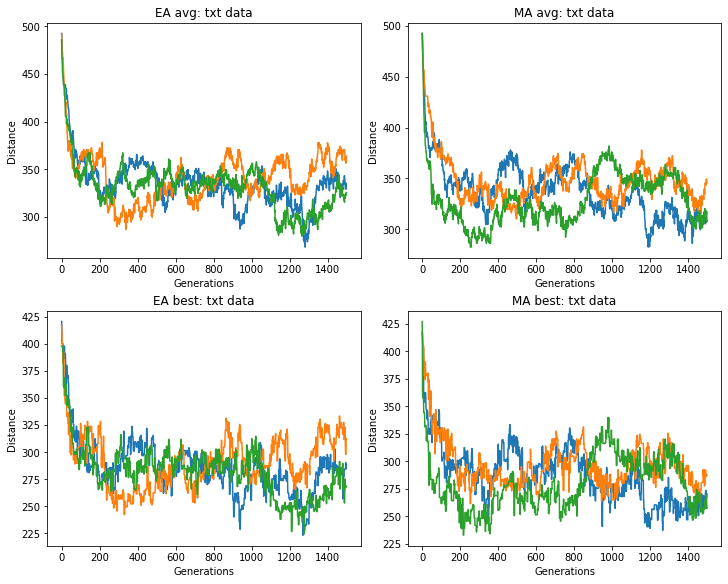

In [42]:
create_data(3, 'txt data', txt_data, 1500, 300)

**(c)**

**(d)**

**(e)**

**(f)**

## References:

[1] Automatic Combination of Operators in a Genetic Algorithm to Solve the Traveling Salesman Problem

In [ ]:
    def _EA_TSP__local_opt(self, child):
        current_dist = self._EA_TSP__tot_distance(child)
        current_child = child
          # apply 2-opt untill no improvements are made:
        while True:
            
            change = False
            
            for idx in range(len(self._d_data[0])):
                for idy in range(idx + 1, len(self._d_data[0])):
                    child, new_dist = self.__two_opt_step(child, idx, idy)

                    if new_dist < current_dist:
                        change = True
                        current_dist = new_dist
                        current_child = child

            if not change:
                break
        return current_child